# 2022机器学习期末大作业：基于VAE的手写数字生成

## 实验要求
### 1.基本要求
利用 pytorch (推荐) 或 tensorflow 等神经网络框架编程实现一个变分自编码器 (Variational Auto Encoder, VAE)；分别采用交叉熵损失 (Cross Entropy Loss) 和L2损失 (MSE Loss) 构建损失函数生成新的手写数字,分析结果并展示生成的手写数字；
### 2.中级要求：
实现VAE的变分推断(最好是手写推导)，描述VAE的由来以及优缺点；
### 3.提高要求：
实现任意形式的对VAE进行改进或创新，例如：和其他网络结合或对比（图卷积神经网络(GCN)，生成对抗网络(GAN)，Diffusion Model等）；实现VAE的变种（β-VAE，β-TCVAE等）；修改数据集（例如加噪点，加mask等）以发掘VAE更多的功能；对可视化方法进行创新（例如输出隐变量）……

## 小组介绍
- 成员组成：
    - 2011283 林筠皓 计算机科学与技术
    - 2010249 宋昊雨 计算机科学与技术
    - 2013921 周延霖 信息安全
- 成员贡献：
    - 林筠皓：
        1. 学习pytorch神经网络框架，和其他组员共同完成编程实现VAE
        2. 编程实现GAN以生成MNIST数据集，并将其与VAE进行对比；
    - 宋昊雨：
        1. 学习pytorch神经网络框架，和其他组员共同完成编程实现VAE
        2. 实现VAE的变分推断，并介绍其由来以及优缺点；
    - 周延霖：
        1. 学习pytorch神经网络框架，和其他组员共同完成编程实现VAE
        2. 编程实现DCGAN以生成MNIST数据集，并将其与VAE进行对比；
       

## 1.基本要求
利用 pytorch (推荐) 或 tensorflow 等神经网络框架编程实现一个变分自编码器 (Variational Auto Encoder, VAE)；分别采用交叉熵损失 (Cross Entropy Loss) 和L2损失 (MSE Loss) 构建损失函数生成新的手写数字,分析结果并展示生成的手写数字

### 1.1 定义变分自编码器VAE

In [115]:
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np
import os
from torchvision.utils import save_image

In [116]:
# 定义变分自编码器VAE
class VAE(nn.Module):
    def __init__(self):
        # 输入维度是784，中间Encoder、Decoder的维度是256和64，隐变量维度是20

        super(VAE, self).__init__()

        # 定义编码器
        self.Encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU()
        )

        # 定义解码器
        self.Decoder = nn.Sequential(
            nn.Linear(20, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )

        self.fc_m = nn.Linear(64, 20)  # 原有编码
        self.fc_sigma = nn.Linear(64, 20)  # 控制噪音干扰程度的编码

    # 编码
    def encode(self, code):
        return self.Encoder(code)

    # 重参数化生成隐变量
    def reparameterize(self, m, sigma):
        e = torch.randn_like(sigma)
        c = torch.exp(sigma) * e + m
        return c

    # 解码
    def decode(self, code):
        return self.Decoder(code)

    # 整个前向传播过程：编码 --> 解码
    def forward(self, input):
        code = input.view(input.size(0), -1)  # 展平
        code = self.encode(code)

        m = self.fc_m(code)
        sigma = self.fc_sigma(code)
        c = self.reparameterize(m, sigma)

        output = self.decode(c)
        output = output.view(input.size(0), 1, 28, 28)

        return output, m, sigma

In [131]:
# 定义超参数
learning_rate = 1e-3  # 学习率
batch_size = 64  # 数据集切分，每个batch大小为128
epoch_size = 30  # 迭代30次

sample_dir = "generated_result"
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# 训练集下载
dataset = MNIST(root='MNIST', train=True, transform=transforms.ToTensor(), download=True)
dataIter = Data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
# 查看张量的维度数：N(num),C(channel),H(height),W(width)
# x, y = next(iter(dataIter))
# x.shape
# torch.Size([128, 1, 28, 28]), 表示每个batch有128张图，只有一个channel(黑白)，长宽分别是28*28

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 设备

### 1.2 采用L2损失构建损失函数，并进行训练

In [117]:
# 定义并导入网络结构
model = VAE().to(device)

# 创建优化器
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# MSE损失函数
criterion = nn.MSELoss()

In [118]:
# 训练
for epoch in range(epoch_size):
    for batch_index, (real_image, _) in enumerate(dataIter):
        real_image = real_image.to(device)

        # 生成图像
        fake_image, m, sigma = model(real_image)

        # 计算KL损失
        KLD = 0.5 * torch.sum(
            torch.pow(m, 2) +
            torch.pow(sigma, 2) -
            torch.log(1e-8 + torch.pow(sigma, 2)) - 1
        ) / (real_image.size(0) * 28 * 28)

        # 计算均方差损失
        reconstruction_error = criterion(fake_image, real_image)
        # MSE = torch.sum(torch.pow(fake_image - real_image, 2)) / (real_image.size(0) * 1 * 28 * 28)

        # 计算总损失函数
        loss = reconstruction_error + KLD

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 输出batch信息
        if batch_index % 200 == 0 and batch_index > 0:
            print("epoch : {0}/{1} | #batch : {2} | batch average loss: {3}"
                  .format(epoch, epoch_size, batch_index, loss.cpu().item() / len(real_image)))


# 保存模型
torch.save(model.state_dict(), os.path.join(sample_dir, 'VAE_MSELoss.ckpt'))

epoch : 0/30 | #batch : 200 | batch average loss: 0.001032007159665227
epoch : 0/30 | #batch : 400 | batch average loss: 0.0009698052890598774
epoch : 0/30 | #batch : 600 | batch average loss: 0.0008733476861380041
epoch : 0/30 | #batch : 800 | batch average loss: 0.0007979287765920162
epoch : 1/30 | #batch : 200 | batch average loss: 0.0007429500692524016
epoch : 1/30 | #batch : 400 | batch average loss: 0.0006710350280627608
epoch : 1/30 | #batch : 600 | batch average loss: 0.000593906152062118
epoch : 1/30 | #batch : 800 | batch average loss: 0.0006081443862058222
epoch : 2/30 | #batch : 200 | batch average loss: 0.000568298390135169
epoch : 2/30 | #batch : 400 | batch average loss: 0.0005738079198636115
epoch : 2/30 | #batch : 600 | batch average loss: 0.000590670679230243
epoch : 2/30 | #batch : 800 | batch average loss: 0.0005849357112310827
epoch : 3/30 | #batch : 200 | batch average loss: 0.0005677458830177784
epoch : 3/30 | #batch : 400 | batch average loss: 0.0005150472279638

In [126]:
# 导入模型
model = VAE()
model.load_state_dict(torch.load(os.path.join(sample_dir, 'VAE_MSELoss.ckpt')))

# evaluation 测试生成效果，从正态分布随机采样z
z = torch.randn((batch_size, 20))
logits = model.decode(z)  # 仅通过解码器生成图片
x_hat = logits.view(z.size(0), 1, 28, 28)

save_image(x_hat, os.path.join(sample_dir, 'VAE_MSELoss_generated_image.png'), nrow=8, normalize=True)
print("generate success")

<All keys matched successfully>

generate success


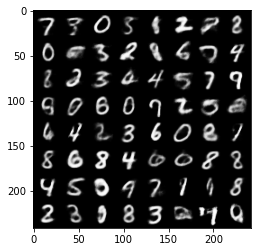

In [127]:
X = plt.imread(os.path.join(sample_dir, 'VAE_MSELoss_generated_image.png'))
plt.imshow(X)

### 1.3 采用交叉熵损失构建损失函数，并进行训练

In [121]:
# 定义并导入网络结构
model = VAE().to(device)

# 创建优化器
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

criterion = nn.BCELoss()

In [122]:
# 训练
for epoch in range(epoch_size):
    for batch_index, (real_image, _) in enumerate(dataIter):
        real_image = real_image.to(device)

        # 生成图像
        fake_image, m, sigma = model(real_image)

        # 计算KL损失
        KLD = 0.5 * torch.sum(
            torch.pow(m, 2) +
            torch.pow(sigma, 2) -
            torch.log(1e-8 + torch.pow(sigma, 2)) - 1
        ) / (real_image.size(0) * 28 * 28)

        # 计算交叉熵损失
        reconstruction_error = criterion(fake_image, real_image)

        # 计算总损失函数
        loss = reconstruction_error + KLD

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 输出batch信息
        if batch_index % 200 == 0 and batch_index > 0:
            print("epoch : {0}/{1} | #batch : {2} | batch average loss: {3}"
                  .format(epoch, epoch_size, batch_index, loss.cpu().item() / len(real_image)))


# 保存模型
torch.save(model.state_dict(), os.path.join(sample_dir, 'VAE_CrossEntropyLoss.ckpt'))

epoch : 0/30 | #batch : 200 | batch average loss: 0.0038945567794144154
epoch : 0/30 | #batch : 400 | batch average loss: 0.0035617349203675985
epoch : 0/30 | #batch : 600 | batch average loss: 0.0031292142812162638
epoch : 0/30 | #batch : 800 | batch average loss: 0.0028971792198717594
epoch : 1/30 | #batch : 200 | batch average loss: 0.0026545063592493534
epoch : 1/30 | #batch : 400 | batch average loss: 0.002485292498022318
epoch : 1/30 | #batch : 600 | batch average loss: 0.0024552377872169018
epoch : 1/30 | #batch : 800 | batch average loss: 0.002376042539253831
epoch : 2/30 | #batch : 200 | batch average loss: 0.002169606275856495
epoch : 2/30 | #batch : 400 | batch average loss: 0.0022147181443870068
epoch : 2/30 | #batch : 600 | batch average loss: 0.0023133044596761465
epoch : 2/30 | #batch : 800 | batch average loss: 0.0021862576249986887
epoch : 3/30 | #batch : 200 | batch average loss: 0.002147485502064228
epoch : 3/30 | #batch : 400 | batch average loss: 0.0022299366537481

In [129]:
# 导入模型
model = VAE()
model.load_state_dict(torch.load(os.path.join(sample_dir, 'VAE_CrossEntropyLoss.ckpt')))

# evaluation 测试生成效果，从正态分布随机采样z
# z = torch.randn((batch_size, 20))
logits = model.decode(z)  # 仅通过解码器生成图片
x_hat = logits.view(z.size(0), 1, 28, 28)

save_image(x_hat, os.path.join(sample_dir, 'VAE_CrossEntropyLoss_generated_image.png'), nrow=8, normalize=True)
print("generate success")

<All keys matched successfully>

generate success


### 1.4 结果展示与分析对比

1. 采用L2损失构建损失函数生成新的手写数字：

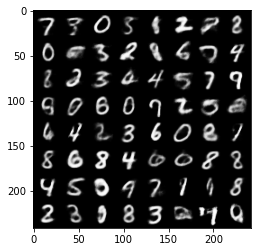

In [128]:
X = plt.imread(os.path.join(sample_dir, 'VAE_MSELoss_generated_image.png'))
plt.imshow(X)

2. 采用交叉熵损失构建损失函数生成新的手写数字：

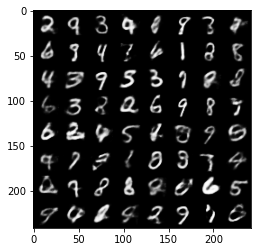

In [130]:
Y = plt.imread(os.path.join(sample_dir, 'VAE_CrossEntropyLoss_generated_image.png'))
plt.imshow(Y)

从展示的结果来看，在保持模型其他参数和用于生成展示图像的隐变量相同的情况下，使用L2损失函数构建的VAE生成的手写数字比使用交叉熵损失函数的要清晰一些。  

分析两者在训练过程中的训练误差，L2损失在第一个epoch时为0.0010，在10个epoch之后就变化不大了，直到训练结束都维持在0.00045左右；而交叉熵损失在第一个epoch时为0.0038，而在5个epoch之后就没有明显地减少了，一直在0.0020左右变动。这可能与交叉熵损失的不对称性有关，从而导致对于MNIST数据集来说使用L2损失要比使用交叉熵损失更合适。  

此外，在训练的过程中发现隐变量的维度与生成的图像质量有很大的关系。当隐变量维度为10时，生成的手写数字都很模糊且大多数都是0，在将隐变量维度调整为20后，即可产生以上的较为清晰的训练结果。这可能是隐变量的维度不够，不足以保留过多的信息所导致的。

## 2. 中级要求

## 3.提高要求

### 3.1 编程实现GAN并生成MNIST数据集
#### 3.1.1 GAN的基本原理
假设我们有两个网络，G(Generator)和D(Discriminator)。正如它的名字所暗示的那样，它们的功能分别是：
- G是一个生成图片的网络，它接收一个随机的噪声z，通过这个噪声生成图片，记做G(z)。
- D是一个判别网络，判别一张图片是不是“真实的”。它的输入参数是x，x代表一张图片，输出D（x）代表x为真实图片的概率，如果为1，就代表100%是真实的图片，而输出为0，就代表不可能是真实的图片。

在训练过程中，生成网络G的目标就是尽量生成真实的图片去欺骗判别网络D。而D的目标就是尽量把G生成的图片和真实的图片分别开来。这样，G和D构成了一个动态的“博弈过程”。
在最理想的状态下，G可以生成足以“以假乱真”的图片G(z)。对于D来说，它难以判定G生成的图片究竟是不是真实的，因此D(G(z)) = 0.5。
![GAN原理图](src/GAN_instruction.png "GAN原理图")

- 判别网络的设计  
    - 为了加快训练速度，判别网络选用一个简单的多层神经网络。其将图片28x28展开成784，然后通过多层感知机，中间经过斜率设置为0.2的LeakyReLU激活函数，最后使用sigmoid激活函数得到一个0到1之间的概率进行二分类。
    - 判别网络的训练由两部分组成，第一部分是计算判别网络对真图的判断能力，第二部分计算其对假图的判断能力，之后计算两者之和，并更新判别网络的更新参数

- 生成网络的设计  
    - 同样，为了加快训练速度，生成网络也使用简单的多层感知机。其输入为一个64维的0～1之间的高斯分布，然后通过第一层线性变换将其映射到256维，然后通过ReLU激活函数，接着进行一个线性变换，再经过一个ReLU激活函数，然后经过线性变换将其变成784维，最后通过Tanh激活函数将生成的图片数据分布映射在-1～1之间。
    - 生成网络的训练则通过生成一张假的图片，将假的图片传入判别网络的结果与真实的label对应，根据结果反向传播更新生成网络的参数，这样就达到了生成对抗的作用。

#### 3.1.2 GAN的代码

In [9]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import torch.utils.data as Data
from torchvision.datasets import MNIST
import os
import matplotlib.pyplot as plt

In [136]:
# 定义生成对抗网络GAN
image_size = 784
hidden_size = 256
latent_size = 64


# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.dis = nn.Sequential(
            nn.Linear(image_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.dis(x)
        return x


# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, image_size),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.gen(x)
        return x


# 定义超参数
learning_rate = 0.0002
batch_size = 64
epoch_size = 50

In [25]:
sample_dir = "generated_result"
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# 训练集下载
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5)
])
dataset = MNIST(root='MNIST', train=True, transform=transform, download=True)
dataloader = Data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 定义并导入网络结构
D = Discriminator().to(device)
G = Generator().to(device)

# 创建优化器
d_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)
g_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate)

# MSE损失函数
criterion = nn.BCELoss()

# 训练
for epoch in range(epoch_size):
    for batch_idx, (real_images, _) in enumerate(dataloader):
        num_img = real_images.size(0)
        real_images = real_images.view(num_img, -1).to(device)

        real_labels = torch.ones(num_img, 1).to(device)
        fake_labels = torch.zeros(num_img, 1).to(device)

        # 对 Discriminator 进行训练
        # 对真图的判断能力
        outputs = D(real_images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # 对假图的判断能力
        z = torch.randn(num_img, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # 优化
        d_loss = d_loss_real + d_loss_fake  # 总的损失就是以上两部分相加，越小越好
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # 对 Generator 进行训练
        z = torch.randn(num_img, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)

        # 开始优化generator
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        if batch_idx % 300 == 0 and batch_idx > 0:
            print("epoch: {}/{} | #batch: {}/{}, d_loss: {:.4f}, g_loss: {:.4f}, real_score: {:.2f}, fake_score: {:.2f}"
                  .format(epoch, epoch_size, batch_idx, len(dataloader),
                          d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))


# 保存模型
torch.save(D.state_dict(), os.path.join(sample_dir, 'GAN_Discriminator.ckpt'))
torch.save(G.state_dict(), os.path.join(sample_dir, 'GAN_Generator.ckpt'))

epoch: 0/50 | #batch: 300/938, d_loss: 0.2510, g_loss: 3.1302, real_score: 0.90, fake_score: 0.13
epoch: 0/50 | #batch: 600/938, d_loss: 0.0517, g_loss: 5.5497, real_score: 0.98, fake_score: 0.03
epoch: 0/50 | #batch: 900/938, d_loss: 0.0552, g_loss: 4.5595, real_score: 0.98, fake_score: 0.03
epoch: 1/50 | #batch: 300/938, d_loss: 0.7575, g_loss: 5.2153, real_score: 0.79, fake_score: 0.14
epoch: 1/50 | #batch: 600/938, d_loss: 0.1898, g_loss: 3.0878, real_score: 0.93, fake_score: 0.06
epoch: 1/50 | #batch: 900/938, d_loss: 0.1450, g_loss: 4.1871, real_score: 0.96, fake_score: 0.07
epoch: 2/50 | #batch: 300/938, d_loss: 0.6986, g_loss: 2.3399, real_score: 0.81, fake_score: 0.22
epoch: 2/50 | #batch: 600/938, d_loss: 0.4928, g_loss: 3.3464, real_score: 0.85, fake_score: 0.16
epoch: 2/50 | #batch: 900/938, d_loss: 0.7757, g_loss: 1.2944, real_score: 0.86, fake_score: 0.39
epoch: 3/50 | #batch: 300/938, d_loss: 0.3829, g_loss: 4.1675, real_score: 0.83, fake_score: 0.03
epoch: 3/50 | #batch

In [134]:
G = Generator()
G.load_state_dict(torch.load(os.path.join(sample_dir, 'GAN_Generator.ckpt')))

z = torch.randn(batch_size, latent_size).to(device)
fake_images = G(z).view(z.size(0), 1, 28, 28)

save_image(fake_images, os.path.join(sample_dir, 'GAN_generated_image.png'), nrow=8, normalize=True)
print("generate success")

<All keys matched successfully>

generate success


#### 3.1.3 对比使用GAN和VAE生成的手写数字

1. 使用GAN生成的手写数字：

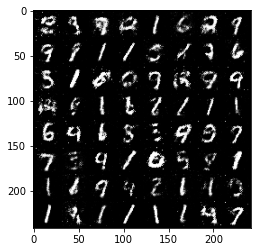

In [135]:
X = plt.imread(os.path.join(sample_dir, 'GAN_generated_image.png'))
plt.imshow(X)

2. 使用VAE生成的手写数字：

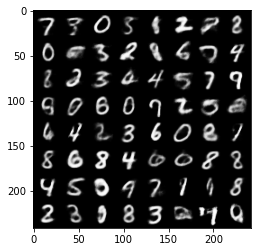

In [133]:
X = plt.imread(os.path.join(sample_dir, 'VAE_MSELoss_generated_image.png'))
plt.imshow(X)

总体来看，虽然从总体来看，使用VAE生成的手写数字明显要比使用GAN生成的手写数字的噪点更少，且更加接近真实的手写数字，但是从清晰程度来看，GAN生成的手写数字要更清晰一些，VAE生成的数字的边界比较模糊。  

分析对比GAN和VAE的框架，GAN的Generator的实际作用和VAE的Decoder是一样的，都是通过一个随机输入产生图片。而为了方便对比两者的效果，本实验中VAE的Decoder和GAN的Generator的结构也都设计成近乎相似，都是通过一个多层感知机，将一个输入的低纬度的高斯分布经过多次的线性映射和ReLU激活函数，将其依次映射为64维、256维度，最后变为784维的图片数据。因此，在本实验中，觉得VAE和GAN生成的图片的质量差异的主要原因则在于这两者如何判断生成图片的质量的。  

VAE是将生成的图片直接和真实图片进行像素级别的对比以计算损失误差，而GAN则是通过学习一个判别器来让生成的图片和真实图片在整体的判断趋于一致。正是由于这种判断生成图片的质量的方式的不同，从而导致两者生成的图片的质量差异。在训练过程中，VAE用于生成图片的隐变量是由输入图片编码产生的，因此该编码和真实的图片对应性更强，生成图像更加规则，但又由于像素级别的对比，故VAE无法更好的关注全局信息，从而导致生成图片比较模糊；而GAN则由于作为隐变量的图片编码是随机输入产生的，故其图片的对应性弱，从而导致生成图像不如VAE生成的图像真实，但又由于GAN的判别网络是对图像整体进行判断的，故生成的图片的连续性更强，生成的手写数字要更加清晰。

### 3.2 编程实现DCGAN并生成MNIST数据集

#### 3.2.1 DCGAN的基本原理

***（一）DCGAN简介***


DCGAN全称Deep Convolutional Generative Adversarial Networks，中文名曰深度卷积对抗网络。


因为DCGAN是不仅与GAN有关还与CNN有关，CNN可以理解为如下的行为，逐层深入"抽丝剥茧”地“理解”一张图片或其他事物。图片经过CNN网络中的一系列layer，逐渐的对图像进行细化，最终将图像从一个大的维度变成一个小的维度。在DCGAN中，判别器实际上就是一个CNN网络。输入一张图片，然后输出`yes or no`的概率。


而在DCGAN中，网络刚好和CNN相反，它是由noise通过网络生成一张图片，因为图片通过layer逐渐变大，与卷积作用刚好相反——因此可以称之为`反卷积`。


***（二）DCGAN特点***


当然，DCGAN除了网络与CNN不同之外，它还有以下的不同：


1. 取消所有pooling层。G网络中使用转置卷积（transposed convolutional layer）进行上采样，D网络中用加入stride的卷积代替pooling。
2. 除了生成器模型的输出层和判别器模型的输入层，在网络其它层上都使用了Batch Normalization，使用BN可以稳定学习，有助于处理初始化不良导致的训练问题。
3. G网络中使用ReLU作为激活函数，最后一层使用tanh
4. D网络中使用LeakyReLU作为激活函数


***（三）重要概念***


> 下采样（subsampled）

下采样实际上就是缩小图像，主要目的是为了使得图像符合显示区域的大小，生成对应图像的缩略图。比如说在CNN中得池化层或卷积层就是下采样。不过卷积过程导致的图像变小是为了提取特征，而池化下采样是为了降低特征的维度。

> 上采样（upsampling）

有下采样也就必然有上采样，上采样实际上就是放大图像，指的是任何可以让图像变成更高分辨率的技术，这时也就能理解为什么在网络中能够由噪声生成一张图片了。


它有反卷积(Deconvolution)、上池化(UnPooling)方法

> 反卷积(Deconvolution)

反卷积(Deconvolution)也称为分数步长的卷积和转置卷积(transposed convolution)。convolution过程是将4×4的图像映射为2×2的图像，而反卷积过程则是将2×2的图像映射为4×4的图像，两者的kernel size均为3。


> 批标准化(Batch Normalization)

需要将数据进行标准化（Normalization），且不仅需要在输入层进行这种操作，且在隐藏层也需要这种操作。Batch normalization 的 batch 是批数据, 把数据分成小批小批进行随机梯度下降。


#### 3.2.2 DCGAN的代码实现

在VAE的训练中，大多数创建的数字看起来都不错。只有一个缺点 ———— 一些创建的图像看起来有点模糊。VAE使用均方误差损失函数进行训练。但是，很难对确切的字符边缘位置进行编码，这导致网络不确定这些边缘。


在DCGAN中，将训练一个不依赖于均方误差或任何相关损失函数的网络——相反，它将自己学习真实图像应该是什么样子。

***（一）深度卷积生成对抗网络***


与VAE一样，DCGAN由两部分组成：

- 判别器学习如何区分想要创建的类型的假货和真品
- 生成器创建新内容并试图欺骗判别器



In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
def montage(images):
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    m = np.ones((images.shape[1] * n_plots + n_plots + 1, images.shape[2] * n_plots + n_plots + 1)) * 0.5
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                m[1 + i + i * img_h:1 + i + (i + 1) * img_h,
                  1 + j + j * img_w:1 + j + (j + 1) * img_w] = this_img
    return m

***（二）基础搭建***

在DCGAN中使用 tensorflow 来访问成批的 MNIST 字符。将批大小设置为 64。这些输入的数量设置为 100。批量规范化大大改善了该网络的训练。为了让 tensorflow 应用批量归一化，需要让它知道我们是否处于训练模式。变量keep_prob将由辍学层使用。我首先尝试将标准 ReLU 应用于这个网络，然后，定义一个函数binary_cross_entropy，稍后在计算损失时将使用它。



In [14]:
tf.__version__

'1.15.4'

In [15]:
print(tf.__file__)

/usr/local/lib/python3.6/dist-packages/tensorflow/__init__.py


In [16]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')
tf.compat.v1.disable_eager_execution()

tf.compat.v1.reset_default_graph()

# import tensorflow.compat.v1 as tf
# tf.reset_default_graph()
batch_size = 64
n_noise = 64

X_in = tf.compat.v1.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
noise = tf.compat.v1.placeholder(dtype=tf.float32, shape=[None, n_noise])

keep_prob = tf.compat.v1.placeholder(dtype=tf.float32, name='keep_prob')
is_training = tf.compat.v1.placeholder(dtype=tf.bool, name='is_training')

def lrelu(x):
    return tf.maximum(x, tf.multiply(x, 0.2))

def binary_cross_entropy(x, z):
    eps = 1e-12
    return (-(x * tf.log(z + eps) + (1. - x) * tf.log(1. - z + eps)))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


***（三）判别器***

现在，可以定义判别器了。它看起来类似于VAE的编码器部分。作为输入，它采用真实或虚假的MNIST数字（28 x 28像素灰度图像）并应用一系列卷积。最后，使用 sigmoid 来确保我们的输出可以解释为输入图像是真实 MNIST 字符的概率

In [17]:
def discriminator(img_in, reuse=None, keep_prob=keep_prob):
    activation = lrelu
    with tf.variable_scope("discriminator", reuse=reuse):
        x = tf.reshape(img_in, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=128, activation=activation)
        x = tf.layers.dense(x, units=1, activation=tf.nn.sigmoid)
        return x

***（四）生成器***


就像VAE中的部分一样，生成器可以接收噪声，并尝试学习如何将噪声转换为数字。为此，它应用了几种转置卷积。起初，我没有对生成器应用批量归一化，它的学习似乎真的很低效。应用批量归一化层后，学习有了很大的改善。此外，我首先有一个更大的密集层接受生成器输入。这导致生成器始终产生相同的输出，无论输入噪声如何。

In [18]:
def generator(z, keep_prob=keep_prob, is_training=is_training):
    activation = lrelu
    momentum = 0.99
    with tf.compat.v1.variable_scope("generator", reuse=None):
        x = z
        d1 = 4
        d2 = 1
        x = tf.layers.dense(x, units=d1 * d1 * d2, activation=activation)
        x = tf.layers.dropout(x, keep_prob)      
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)  
        x = tf.reshape(x, shape=[-1, d1, d1, d2])
        x = tf.image.resize_images(x, size=[7, 7])
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=1, strides=1, padding='same', activation=tf.nn.sigmoid)
        return x    

***（五）损失函数和优化器***


现在，将这两个部分连接在一起，就像之前对VAE的编码器和解码器所做的那样。但是，必须创建判别器的两个对象

- 第一个对象接收真实图像
- 第二个对象接收假图像


第二个对象的重用设置为 True，以便两个对象共享其变量。需要这两个实例来计算两种类型的损失：

- 接收真实图像时，判别器应学习计算高值（接近 1），这意味着它确信输入图像是真实的。
- 接收假图像时，它应该计算低值（接近 0），这意味着它确信输入图像不是真实的


为此，使用前面定义的二进制交叉熵函数。生成器试图实现相反的目标，它试图使判别器为假图像分配高值。

现在，还应用了一些正则化。创建了两个不同的优化器，一个用于判别器，一个用于生成器。必须定义允许这些优化器修改哪些变量，否则生成器的优化器可能会弄乱判别器的变量，反之亦然。

In [19]:
g = generator(noise, keep_prob, is_training)
d_real = discriminator(X_in)
d_fake = discriminator(g, reuse=True)

vars_g = [var for var in tf.trainable_variables() if var.name.startswith("generator")]
vars_d = [var for var in tf.trainable_variables() if var.name.startswith("discriminator")]


d_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(1e-6), vars_d)
g_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(1e-6), vars_g)

loss_d_real = binary_cross_entropy(tf.ones_like(d_real), d_real)
loss_d_fake = binary_cross_entropy(tf.zeros_like(d_fake), d_fake)
loss_g = tf.reduce_mean(binary_cross_entropy(tf.ones_like(d_fake), d_fake))
loss_d = tf.reduce_mean(0.5 * (loss_d_real + loss_d_fake))

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer_d = tf.train.RMSPropOptimizer(learning_rate=0.00015).minimize(loss_d + d_reg, var_list=vars_d)
    optimizer_g = tf.train.RMSPropOptimizer(learning_rate=0.00015).minimize(loss_g + g_reg, var_list=vars_g)
    
    
sess = tf.Session()
sess.run(tf.global_variables_initializer())

***（六）训练***


最后，训练网络。将随机值提供给生成器，生成器将学习从这种噪声中创建数字。还注意不要让生成器和判别器变得太强——否则，这会抑制另一部分的学习，甚至可能阻止网络学习任何东西。

0 0.6894152 0.70111275 0.69351643 0.68531406


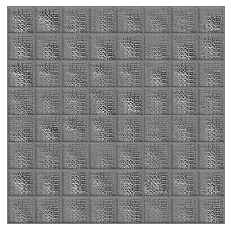

500 0.58353406 1.5257459 0.9028227 0.26424548
not training discriminator


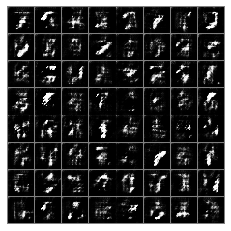

1000 0.60222465 1.4392711 0.9179441 0.28650522
not training discriminator


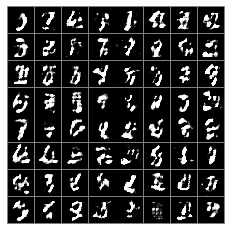

1500 0.5509336 1.1166029 0.6764031 0.42546418
not training discriminator


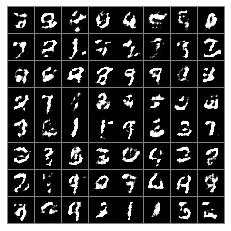

2000 0.53272945 0.9375706 0.49327275 0.5721861


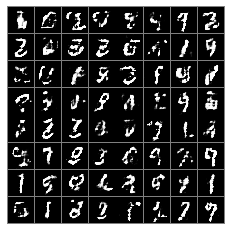

2500 0.60356843 1.3199067 0.86499953 0.34213734
not training discriminator


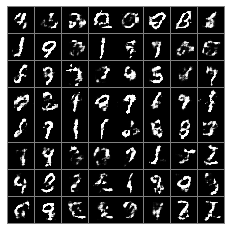

3000 0.6795987 1.5592656 1.0961378 0.26305956
not training discriminator


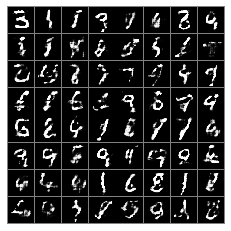

3500 0.5633746 1.2641635 0.76192176 0.36482745
not training discriminator


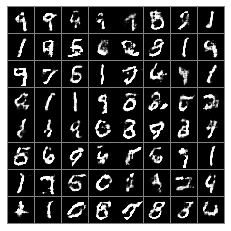

4000 0.5323597 1.2036617 0.6432359 0.42148358
not training discriminator


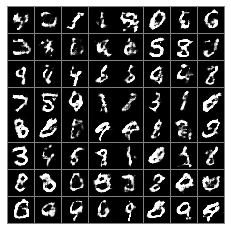

4500 0.62632143 1.5626031 0.9901681 0.26247483
not training discriminator


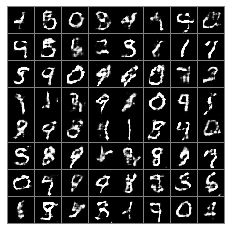

5000 0.5893122 1.4754415 0.8898219 0.2888023
not training discriminator


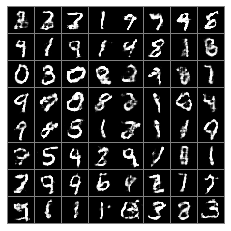

5500 0.5901373 1.4373724 0.8820784 0.29819617
not training discriminator


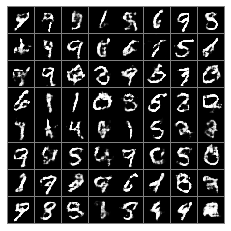

6000 0.5639928 1.3902514 0.7878087 0.34017694
not training discriminator


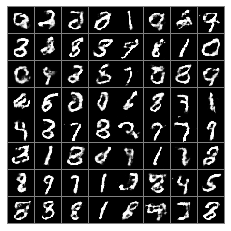

6500 0.61767924 1.2845789 0.8655755 0.36978298
not training discriminator


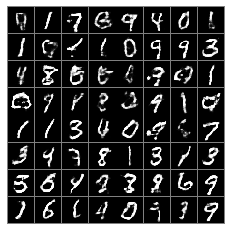

7000 0.60353184 1.1574588 0.77037764 0.43668604


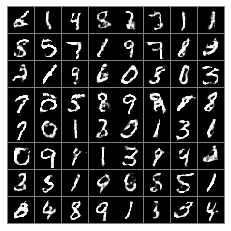

7500 0.5449804 1.3560323 0.7633467 0.3266141
not training discriminator


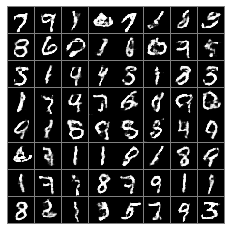

8000 0.61176544 1.3599602 0.8552401 0.36829078
not training discriminator


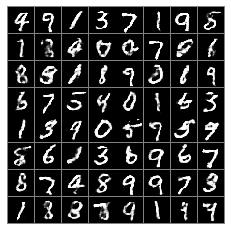

8500 0.6635168 1.4877875 1.0286244 0.29840928
not training discriminator


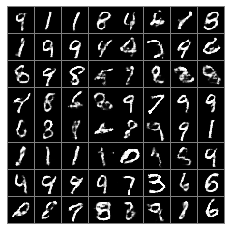

9000 0.56039417 1.3554887 0.7793448 0.3414435
not training discriminator


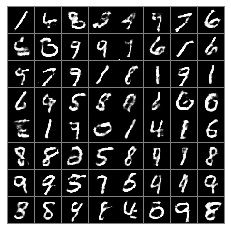

9500 0.559028 1.1503966 0.6955495 0.4225065
not training discriminator


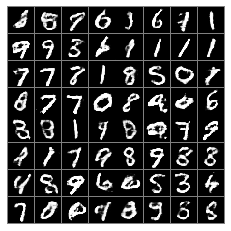

In [20]:
for i in range(10000):
    train_d = True
    train_g = True
    keep_prob_train = 0.6 # 0.5
    
    
    n = np.random.uniform(0.0, 1.0, [batch_size, n_noise]).astype(np.float32)   
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]  
    
    d_real_ls, d_fake_ls, g_ls, d_ls = sess.run([loss_d_real, loss_d_fake, loss_g, loss_d], feed_dict={X_in: batch, noise: n, keep_prob: keep_prob_train, is_training:True})
    
    d_real_ls = np.mean(d_real_ls)
    d_fake_ls = np.mean(d_fake_ls)
    g_ls = g_ls
    d_ls = d_ls
    
    if g_ls * 1.5 < d_ls:
        train_g = False
        pass
    if d_ls * 2 < g_ls:
        train_d = False
        pass
    
    if train_d:
        sess.run(optimizer_d, feed_dict={noise: n, X_in: batch, keep_prob: keep_prob_train, is_training:True})
        
        
    if train_g:
        sess.run(optimizer_g, feed_dict={noise: n, keep_prob: keep_prob_train, is_training:True})
        
        
    if not i % 500:
        print (i, d_ls, g_ls, d_real_ls, d_fake_ls)
        if not train_g:
            print("not training generator")
        if not train_d:
            print("not training discriminator")
        gen_img = sess.run(g, feed_dict = {noise: n, keep_prob: 1.0, is_training:False})
        imgs = [img[:,:,0] for img in gen_img]
        m = montage(imgs)
        gen_img = m
        plt.axis('off')
        plt.imshow(gen_img, cmap='gray')
        plt.show()

#### 3.2.3 结果分析

最后的图片 - 它们看起来比VAE绘制的图片更逼真，VAE的图片在边缘看起来更模糊。然而，训练比训练另一个模型花费的时间要长得多。



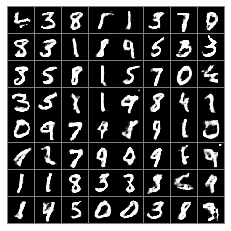

In [21]:
gen_img = sess.run(g, feed_dict = {noise: n, keep_prob: 1.0, is_training:False})
imgs = [img[:,:,0] for img in gen_img]
m = montage(imgs)
gen_img = m
plt.axis('off')
plt.imshow(gen_img, cmap='gray')
plt.show()

总之，训练DCGAN比训练VAE花费的时间要长得多。也许微调架构可以加快网络的学习速度。尽管如此，不依赖于基于像素位置的损失函数，使结果看起来不那么模糊，这是一个真正的优势。这在创建更复杂的数据时尤其重要 - 例如人脸图片。所以，只要有一点耐心——那么在深度学习的世界里一切皆有可能！


## ***最后，也非常感谢学长这一个学期的照顾，祝我们都 `前程似锦` !🎉***